# <en><center>__California Housing Price Analysis__</center></en>

## <en><center>Frantz Alexander</center></en>

#### <en><center>December 23, 2022</center></en>

### <en><center>Project Introduction</center></en>

This analysis will predict housing prices based on neighbourhood housing prices in California

# <en><center>Libraries</center></en>

In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

sns.set_style("ticks")
%matplotlib inline

***

# <en><center>Prepare Data</center></en>

## Import Data

In [131]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    
    # Drop High Multicollinearity columns
    drop_columns = ["Tot_Bedrooms", "Population", "Households"]
    
    # Drop High Multicollinearity Distance to city columns
    city_columns = ["Distance_to_LA", "Distance_to_SanDiego", "Distance_to_SanJose", "Distance_to_SanFrancisco"]
    drop_columns.extend(city_columns)
    
    # Drop leaky columns
    drop_columns.append("Median_Income")
    
    # Drop columns
    df.drop(columns = drop_columns,  inplace = True)
    
    # Remove outliers to "Median_House_Value"
    low, high = df["Median_House_Value"].quantile([0.1, 0.9])
    mask_price = df["Median_House_Value"].between(low, high)
    
    df = df[mask_price]
    
    
    return df

In [132]:
df = wrangle("California_Houses.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16516 entries, 1 to 20639
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Median_House_Value  16516 non-null  float64
 1   Median_Age          16516 non-null  int64  
 2   Tot_Rooms           16516 non-null  int64  
 3   Latitude            16516 non-null  float64
 4   Longitude           16516 non-null  float64
 5   Distance_to_coast   16516 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 903.2 KB


,Median_House_Value,Median_Age,Tot_Rooms,Latitude,Longitude,Distance_to_coast
1,358500.0,21,7099,37.86,-122.22,10225.733072
2,352100.0,52,1467,37.85,-122.24,8259.085109
3,341300.0,52,1274,37.85,-122.25,7768.086571
4,342200.0,52,1627,37.85,-122.25,7768.086571
5,269700.0,52,919,37.85,-122.25,7768.086571


***

## Data Exploration

Display of the columns in the dataset.

In [33]:
for col in df.columns:
    print(col)

Median_House_Value
Median_Income
Median_Age
Tot_Rooms
Tot_Bedrooms
Population
Households
Latitude
Longitude
Distance_to_coast
Distance_to_LA
Distance_to_SanDiego
Distance_to_SanJose
Distance_to_SanFrancisco


Displaying the number of unique values

In [34]:
df.nunique()

Median_House_Value           3842
Median_Income               12928
Median_Age                     52
Tot_Rooms                    5926
Tot_Bedrooms                 1928
Population                   3888
Households                   1815
Latitude                      862
Longitude                     844
Distance_to_coast           12590
Distance_to_LA              12590
Distance_to_SanDiego        12590
Distance_to_SanJose         12590
Distance_to_SanFrancisco    12590
dtype: int64

Checking the number of null values.

In [35]:
df.isnull().sum()

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

Visualization for the Distribution of California Median House Values

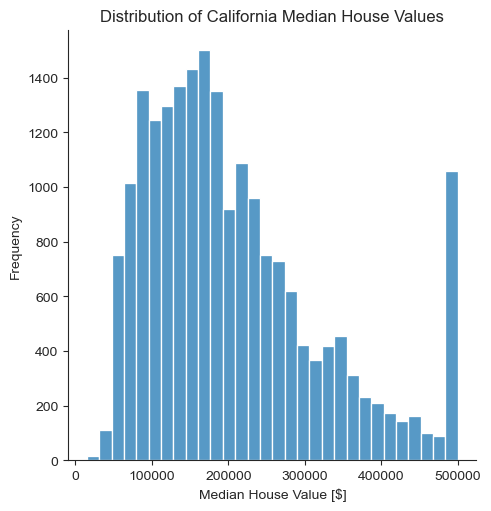

In [36]:
sns.displot(
    df["Median_House_Value"], 
    bins = 30
)
plt.xlabel("Median House Value [$]")
plt.ylabel("Frequency")
plt.title("Distribution of California Median House Values");

In [41]:
df["Median_House_Value"].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: Median_House_Value, dtype: float64

The distribution is positively skewed.

There are significant outliers in the median house value.

- The 75th percentile is at $264,000.

- The highest data point is at $500,000.

- The lowest data point is at $15,000.

Visualization for the Distribution of California Median House Values after the removal of outliers

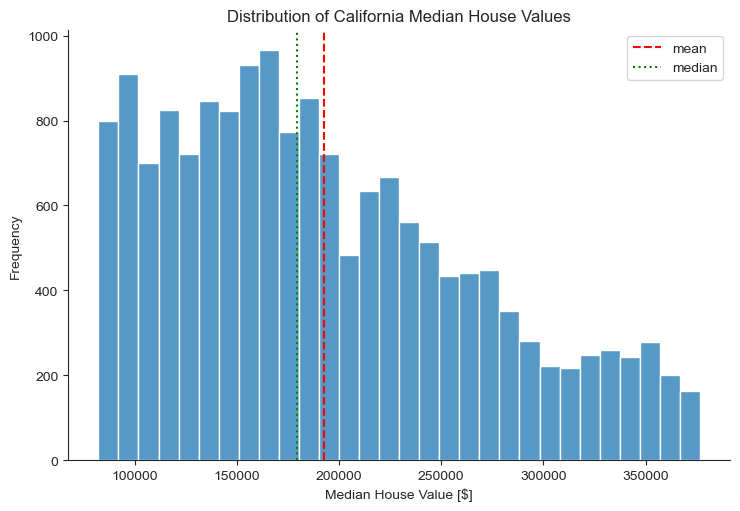

In [130]:
sns.displot(
    df["Median_House_Value"], 
    bins = 30,
    aspect = 1.5
)
plt.axvline(
    np.mean(df["Median_House_Value"]),
    ls = "--",
    label = "mean",
    color = "red"
    
)
plt.axvline(
    np.median(df["Median_House_Value"]),
    ls = ":",
    label = "median",
    color = "green"
)
plt.xlabel("Median House Value [$]")
plt.ylabel("Frequency")
plt.title("Distribution of California Median House Values")
plt.legend();

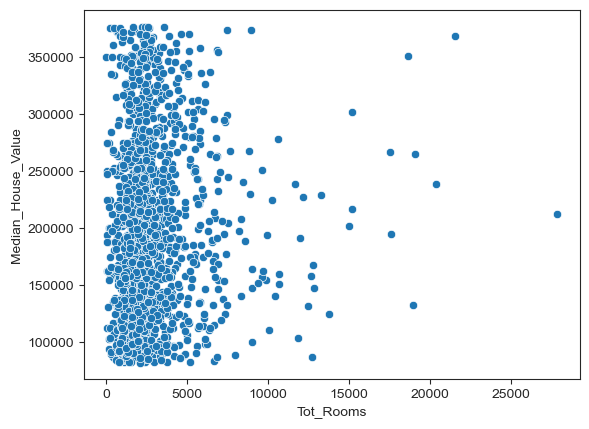

In [77]:
sns.scatterplot(
    data = df.sample(frac = 0.1),
    x = "Tot_Rooms", 
    y = "Median_House_Value", 
);

In [91]:
df["Median_House_Value"].corr(df["Median_Income"])

0.6880752079585477

Visualization of the Correlation Matrix

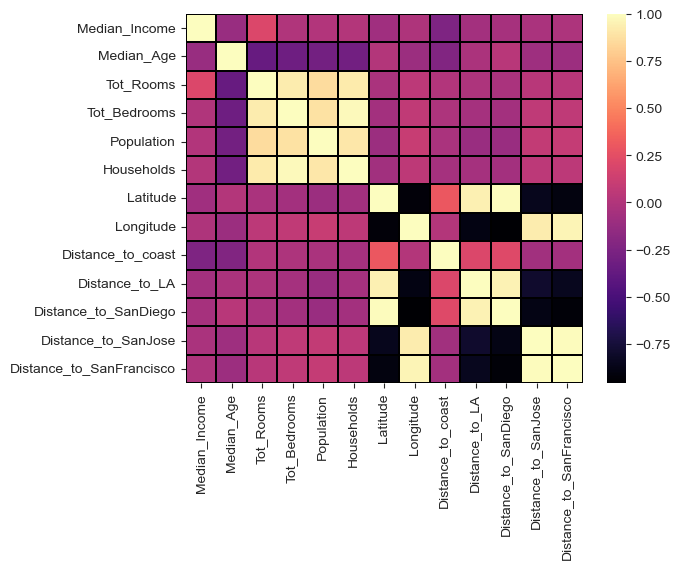

In [90]:
corr = df.drop(columns = "Median_House_Value").corr()
sns.heatmap(
    corr,
    cmap = "magma",
    linecolor = "black",
    linewidths = 0.1
);

Visualization of the Correlation Matrix after the removal of Multicollinearity Features.

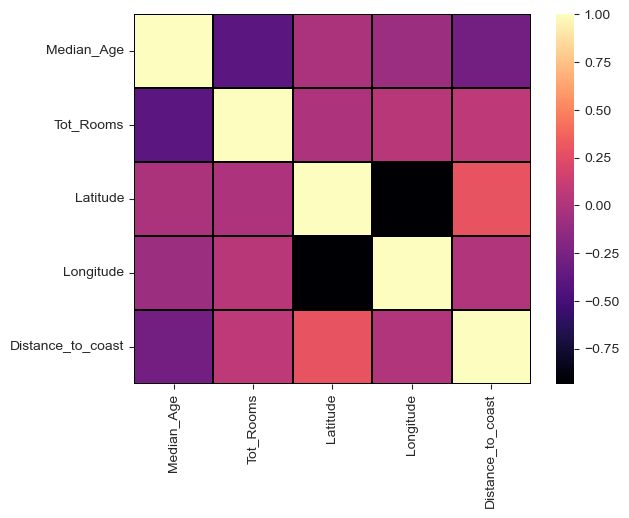

In [95]:
corr = df.drop(columns = "Median_House_Value").corr()
sns.heatmap(
    corr,
    cmap = "magma",
    linecolor = "black",
    linewidths = 0.1
);

Multicollinearity

In [26]:
columns = ["Median_Income","Tot_Bedrooms", "Population", "Households"]

Visualizing the Relationship between Median House Value with Latitude & Longitude

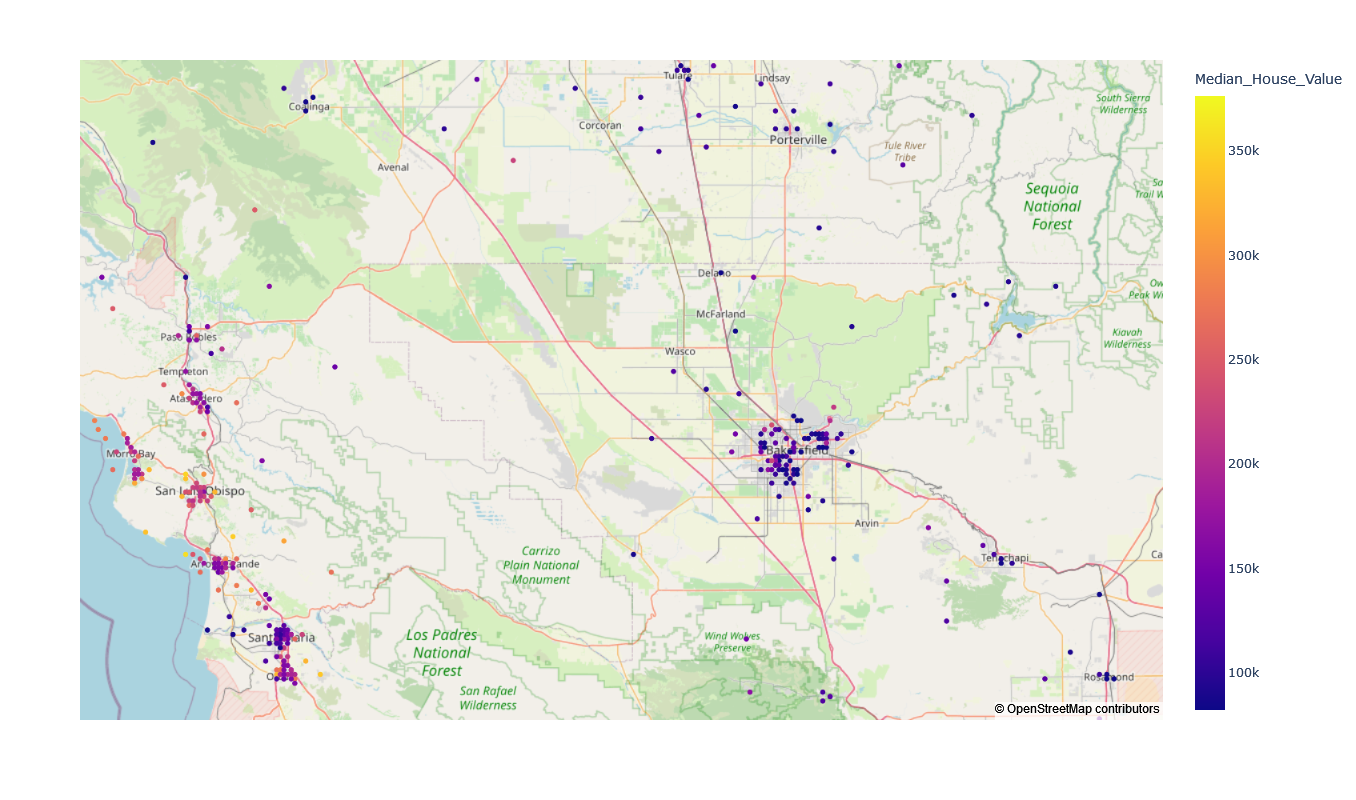

In [135]:
fig = px.scatter_mapbox(
    df,
    lat = "Latitude",
    lon = "Longitude",
    width = 800,
    height = 800,
    color = "Median_House_Value",
    hover_data = ["Median_House_Value"]
)
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

There is a strong visual relationship between the Median House Value and the proximity to the coastline. 

## Train-Test Split

In [102]:
target = "Median_House_Value"

X = df.drop(columns = "Median_House_Value")
y = df[target]

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2, 
    random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (13212, 5)
y_train shape: (13212,)
X_test shape: (3304, 5)
y_test shape: (3304,)


# <en><center>Model Building</center></en>

## Baseline

Calculate the Baseline Mean Absolute Error 

In [113]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean House Value:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))


Mean House Value: 192368.52
Baseline MAE: 61803.73488779684


## Iterate

Instantiate and fitting Linear Regressor

In [114]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluation

Calculating the Mean Absolute Error for predictions compared to the true values.

In [117]:
y_pred_training = model.predict(X_train)
print("Training Mean Absolute Error:", mean_absolute_error(y_train, y_pred_training))

Training Mean Absolute Error: 52717.308022006204


In [118]:
y_pred_test = model.predict(X_test)
print("Test Mean Absolute Error:", mean_absolute_error(y_test, y_pred_test))

Test Mean Absolute Error: 52901.12900961937


The model performed slightly worse on the test set than the training set.

The model is shown the capacity to generalize to new data. 

# <en><center>Communication</center></en>

In [122]:
intercept = model.intercept_
coefficients = model.coef_
print("Coefficients length: ", len(coefficients))
print(coefficients[:5])

Coefficients length:  5
[-1.19540226e+02  4.71341200e+00 -3.59451791e+04 -3.85143570e+04
 -1.96332840e-01]


In [124]:
feature_names = model.feature_names_in_

In [125]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

Median_Age            -119.540226
Tot_Rooms                4.713412
Latitude            -35945.179102
Longitude           -38514.357015
Distance_to_coast       -0.196333
dtype: float64

In [127]:
print(f"price = {intercept.round(2)}")
for f,c  in feat_imp.items():
    print(f"+ ({round(c,2)} * {f})")

price = -3136106.71
+ (-119.54 * Median_Age)
+ (4.71 * Tot_Rooms)
+ (-35945.18 * Latitude)
+ (-38514.36 * Longitude)
+ (-0.2 * Distance_to_coast)
